# Plot matern correlation functions in lat/lon and lat (orlon)/z space

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
import cartopy.crs as ccrs

from corrpacmap import CorrelationPacMap
from llcmap import PacificMap

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [3]:
plt.style.use('./correlation.mplstyle')

In [43]:
n_applications = 2
main_dir = f'/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-pacmap-{n_applications:02d}apps'
ds = xr.open_zarr(f'{main_dir}/equator.20dx.01xi/')
ds2 = xr.open_zarr(f'{main_dir}/coast.20dx.01xi/')
for key in ds2.data_vars:
    ds[key] = ds2[key]
ds = ds.squeeze()

In [44]:
ds.load();

### The map

In [45]:
mapper = PacificMap(ds)

In [46]:
cmap1 = plt.get_cmap("Purples", 10)
cmap2 = cmap1.copy()
cmap2.set_bad([.8]*3)

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


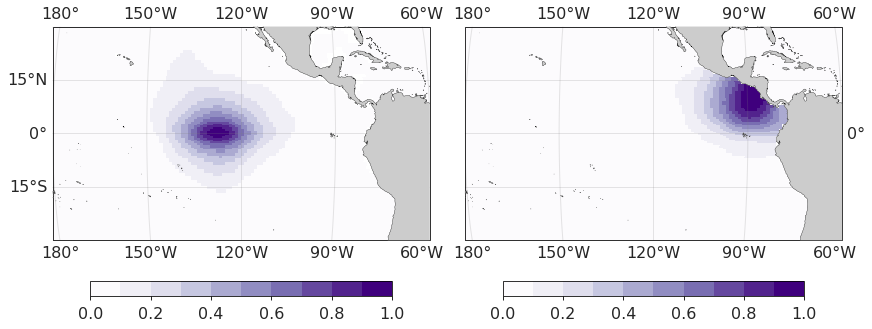

In [47]:
fig, axs = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True,
                        subplot_kw={"projection":ccrs.Robinson(central_longitude=-120)})

for fld, k, ax in zip(["corr_equator", "corr_coast"],
                      [25, 0],
                      axs):
    mapper(ds[fld].sel(k=k),
           vmin=0,
           vmax=1,
           cmap=cmap1,
           ax=ax)
    #ax.set_extent([-180, -60, -30, 30], ccrs.PlateCarree())

In [48]:
projection = ccrs.Robinson(central_longitude=-120)
mkw = {'vmin':0, 'vmax':1, 'cmap':cmap1, 'show_cbar': False}
pkw = {'vmin':0, 'vmax':1, 'cmap':cmap2}
xrange = [-180, -60]

/tmp/ipykernel_36009/2357197054.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set(xlim=xrange,
/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


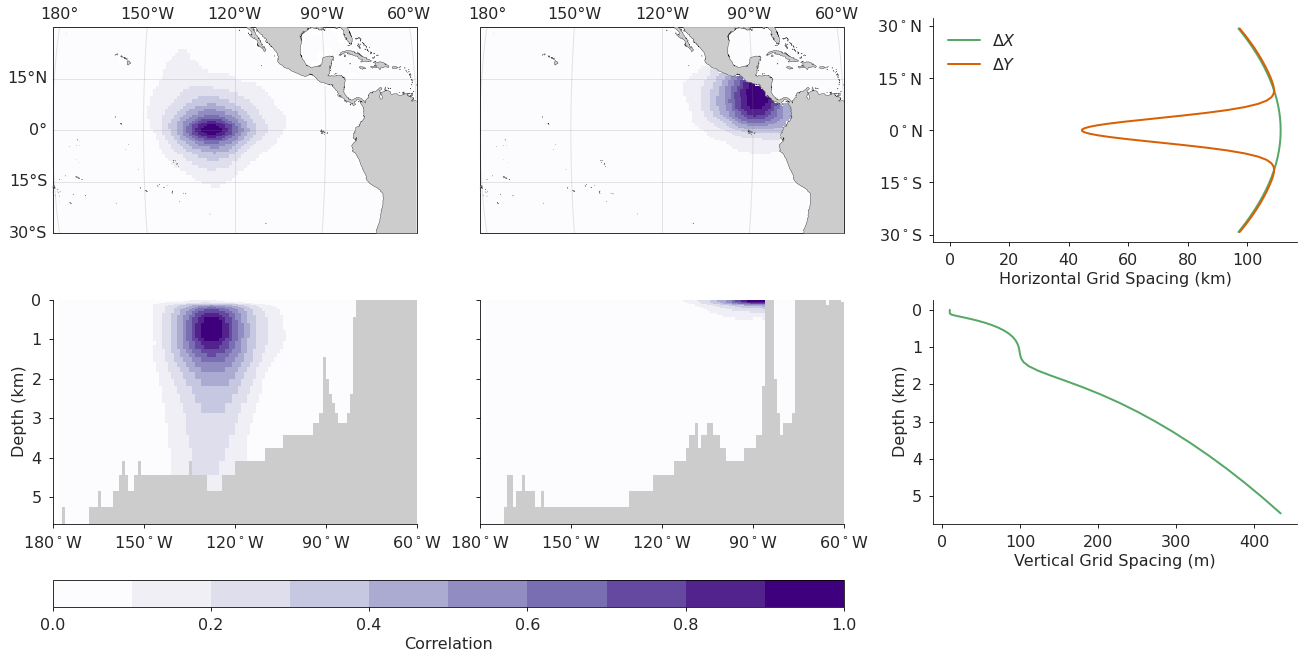

In [49]:
fig = plt.figure(figsize=(18, 9), constrained_layout=True)

axstop = []
axsbot = []

for i, (fld, k, iy) in enumerate(zip(["corr_equator", "corr_coast"],
                                     [25, 0],
                                     [165, 180])):
                                   
    # Lat / Lon
    ax0 = fig.add_subplot(2, 3, i+1, projection=projection)
    mapper(ds[fld].sel(k=k), ax=ax0, **mkw)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    axstop.append(ax0)
    
    # Z / Lon
    ax1 = fig.add_subplot(2, 3, i+4)
    
    xds = ds.sel(ix=slice(40,None))
    pcorr = ax1.pcolormesh(xds.XC.sel(iy=iy), -xds.Z,
                      xds[fld].where(xds.maskC).sel(iy=iy),
                      **pkw)
    ax1.invert_yaxis()
    ifc = ax1.get_subplotspec().is_first_col()
    ylabel = 'Depth (km)' if ifc else ''
    yticklabels = np.arange(6) if ifc else []
    xticklabels = [r"%d$^\circ$W" % lon for lon in np.arange(180, 50, -30)]
    ax1.set(xlim=xrange,
           xticks=np.arange(-180,-50, 30),
           xticklabels=xticklabels,
           ylabel=ylabel,
           yticklabels=yticklabels,
          )
    axsbot.append(ax1)
    
    
# Lat/Lon Grid
ax = fig.add_subplot(2, 3, 3)
yc = ds.YC.sel(ix=90)
yc = yc.where((yc<=30) & (yc>=-30))
# Note that dx and dy are computed quantities,
# and because of the rotated grid at these locations,
# they are swapped in terms of lat/lon interpretation
ax.plot(yc.dyF / 1000, yc, label=r"$\Delta X$")
ax.plot(yc.dxF / 1000, yc, label=r"$\Delta Y$")
ax.set(xlabel="Horizontal Grid Spacing (km)",
       yticks=np.arange(-30, 31, 15),
       yticklabels=[r"%d$^\circ$S" % y for y in [30, 15]]+\
                   [r"%d$^\circ$N" % y for y in [0, 15, 30]])
ax.legend()
axg=ax

# Z grid
ax = fig.add_subplot(2,3,6)
ax.plot(ds.drF, -ds.Z, label=r"$\Delta Z")
ax.invert_yaxis()
ax.set(xlabel="Vertical Grid Spacing (m)",
       ylabel="Depth (km)",
       yticks=np.arange(0,6000,1000),
       yticklabels=np.arange(6))

fig.colorbar(pcorr,
             ax=axsbot[:2],
             orientation='horizontal',
             aspect=30,
             label='Correlation')
fig.savefig(f"{fig_dir}/huge_correlation_map_{n_applications:02d}apps.jpg", dpi=300, bbox_inches='tight')

### Get locations

In [33]:
eq = {'ix': 90, 'iy': 165}#, 'k': 25}
co = {'ix': 130, 'iy': 180}#, 'k': 0}

In [37]:
for loc, kk in zip([eq, co], [25, 0]):
    xc = float(ds.XC.sel(loc))
    yc = float(ds.YC.sel(loc))
    d = -float(ds.Z.sel(k=kk))
    print(f"(Lon, Lat, Depth) = ({xc:.2f}, {yc:.2f}, {d:.2f})")

(Lon, Lat, Depth) = (-127.50, 0.20, 722.40)
(Lon, Lat, Depth) = (-87.50, 10.46, 5.00)
